## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from keras.utils import timeseries_dataset_from_array
import os

## Data pre-processing

In [2]:
def func(timePath, responsePath, timeStamps):
    time_df = pd.read_csv(timePath)
    time_df['attentive'] = 1
    old = 0
    resp_df = pd.read_csv(responsePath)
    for index, row in resp_df.iterrows():
        if(row[' Correct'] == ' Yes'):
            old = row['Elapsed Time (ms)']
            continue
        new = row['Elapsed Time (ms)']
        time_df.loc[(time_df['Elapsed Time (ms)'] >= old) & (time_df['Elapsed Time (ms)'] <= new), 'attentive'] = 0
    
    # Update time_df and remove old ' Pitch' and ' Roll' columns
    # time_df[' Pitch'] = round(((time_df[' Pitch'] + 180) % 360), 2)
    # time_df[' Roll'] = round(((time_df[' Roll'] + 180) % 360), 2)
    # # time_df[' Yaw'] = round(((time_df[' Yaw'] + 180) % 360), 2)
    
    time_df = time_df.drop(['Elapsed Time (ms)', ' Alphabet'], axis=1)
    dataset = timeseries_dataset_from_array(np.asarray(time_df.drop(['attentive'], axis = 1))[: -timeStamps], np.asarray(time_df['attentive'])[timeStamps:], 10, batch_size=71000)
    for index, batch in enumerate(dataset):
        features, labels = batch
        
       
    return features, labels
    
    
features_arr, labels_arr = func('../data/timeFile_1.csv', '../data/responseFile_1.csv', 10)


In [3]:
# List of response and time file paths
response_files = ['responseFile_1.csv', 'responseFile_3.csv', 'responseFile_4.csv', 'responseFile_5.csv', 'responseFile_6.csv', 'responseFile_7.csv']
time_files = ['timeFile_1.csv', 'timeFile_3.csv', 'timeFile_4.csv', 'timeFile_5.csv', 'timeFile_6.csv', 'timeFile_7.csv']

# Process each file and stack the datasets
stacked_features, stacked_labels = None, None
for time_file, response_file in zip(time_files, response_files):
    dataset = func('../data/' + time_file, '../data/' + response_file, 10)
    if stacked_features is None:
        stacked_features, stacked_labels = dataset
    else:
        stacked_features = np.concatenate([stacked_features, dataset[0]], axis=0)
        stacked_labels = np.concatenate([stacked_labels, dataset[1]], axis=0)

# Print the shapes of the stacked datasets
print("Stacked Features Shape:", stacked_features.shape)
print("Stacked Labels Shape:", stacked_labels.shape)

Stacked Features Shape: (120312, 10, 3)
Stacked Labels Shape: (120312,)


In [22]:
# Assuming stacked_features is already defined and available.
# stacked_features.shape[2] should represent the number of features in each input sequence.

# Define the input layer with the shape (10, number of features)
input_layer = tf.keras.layers.Input(shape=(10, stacked_features.shape[2]))

# Define a stack of LSTM layers in a sequential fashion
lstm_layer1 = tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh', recurrent_dropout=0.2, dropout=0)(input_layer)
lstm_layer2 = tf.keras.layers.LSTM(32, activation='tanh', recurrent_dropout=0.2, dropout=0)(lstm_layer1)

# Define the output layer
hidden_layer = tf.keras.layers.Dense(32, activation='relu')(lstm_layer2)
droput_layer = tf.keras.layers.Dropout(0.35)(hidden_layer)
hidden_layer2 = tf.keras.layers.Dense(32, activation='relu')(droput_layer)
droput_layer2 = tf.keras.layers.Dropout(0.1)(hidden_layer2)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(droput_layer2)

# Create the sequential model
sequential_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

sequential_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 32)            4608      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0   

In [28]:
# Compile the model
sequential_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)


# train_features = stacked_features[:100000, :, :]
# train_labels = stacked_labels[:100000]
# test_features = stacked_features[100000:, :, :]
# test_labels = stacked_labels[100000:]

# sc = StandardScaler()
# train_features = sc.fit_transform(stacked_features)
# test_features = sc.transform(test_features)

base_history = sequential_model.fit(train_features, train_labels, batch_size=32, epochs=200,
                                    verbose=1, validation_data=(test_features, test_labels), class_weight={0: 5, 1: 1})

Epoch 1/200


3125/3125 [==============================] - 18s 5ms/step - loss: 0.9252 - accuracy: 0.8973 - val_loss: 0.4968 - val_accuracy: 0.9155
Epoch 2/200
3125/3125 [==============================] - 23s 7ms/step - loss: 0.9252 - accuracy: 0.8973 - val_loss: 0.4980 - val_accuracy: 0.9155
Epoch 3/200
3125/3125 [==============================] - 17s 6ms/step - loss: 0.9252 - accuracy: 0.8973 - val_loss: 0.4988 - val_accuracy: 0.9155
Epoch 4/200
3125/3125 [==============================] - 17s 5ms/step - loss: 0.9252 - accuracy: 0.8973 - val_loss: 0.4993 - val_accuracy: 0.9155
Epoch 5/200
3125/3125 [==============================] - 16s 5ms/step - loss: 0.9252 - accuracy: 0.8973 - val_loss: 0.4996 - val_accuracy: 0.9155
Epoch 6/200
3125/3125 [==============================] - 15s 5ms/step - loss: 0.9252 - accuracy: 0.8973 - val_loss: 0.4997 - val_accuracy: 0.9155
Epoch 7/200
3125/3125 [==============================] - 15s 5ms/step - loss: 0.9252 - accuracy: 0.8973 - val_loss: 0.4998 - val_accurac

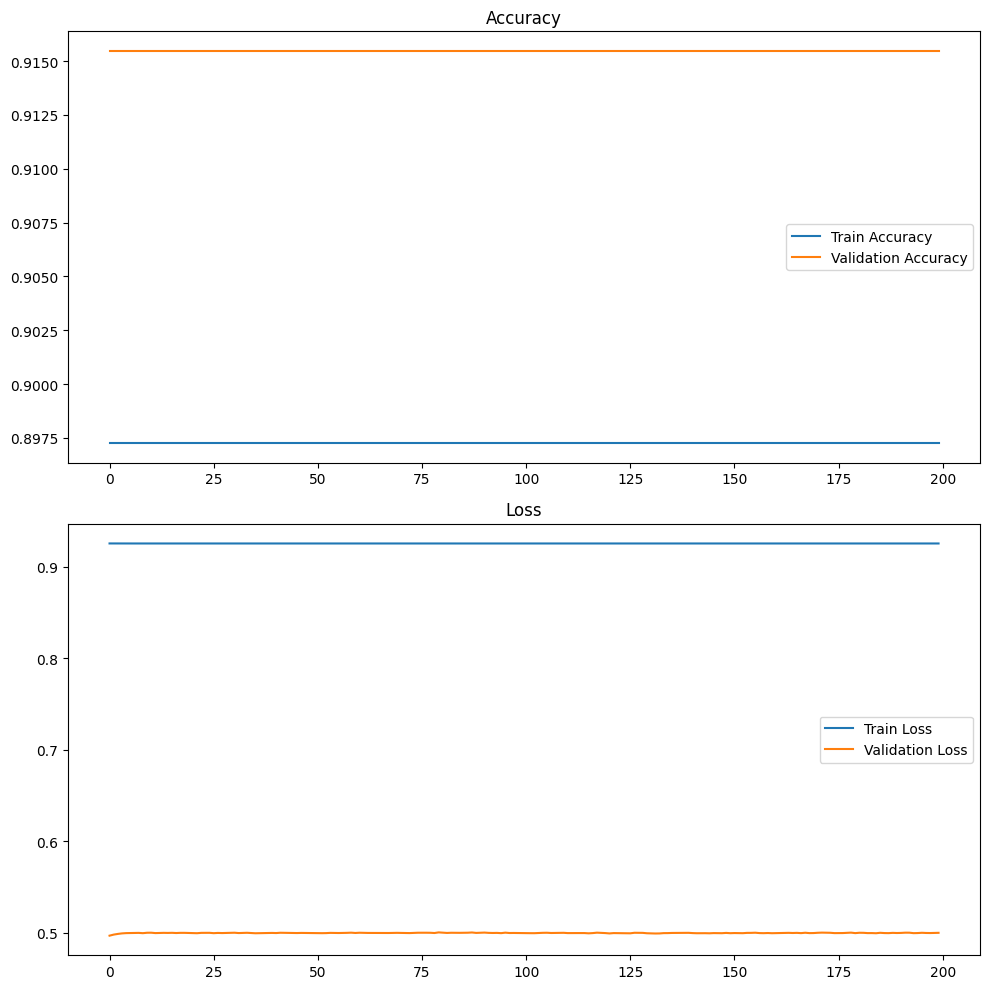

In [29]:
# Plot accuracy and loss
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].plot(base_history.history['accuracy'], label='Train Accuracy')
ax[0].plot(base_history.history['val_accuracy'], label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(base_history.history['loss'], label='Train Loss')
ax[1].plot(base_history.history['val_loss'], label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

plt.tight_layout()
plt.show()

635/635 [==============================] - 1s 2ms/step


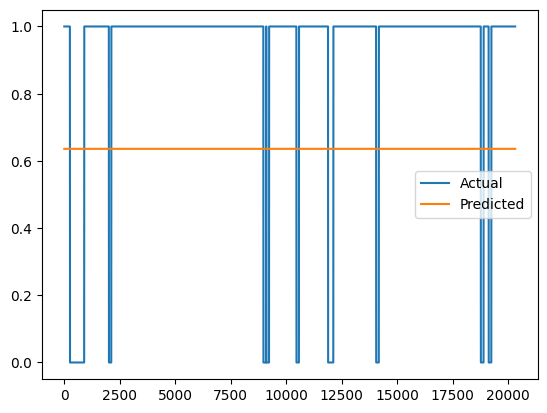

In [30]:
plt.plot(test_labels, label='Actual')
plt.plot(sequential_model.predict(test_features), label='Predicted')
plt.legend()
plt.show()

3125/3125 [==============================] - 7s 2ms/step


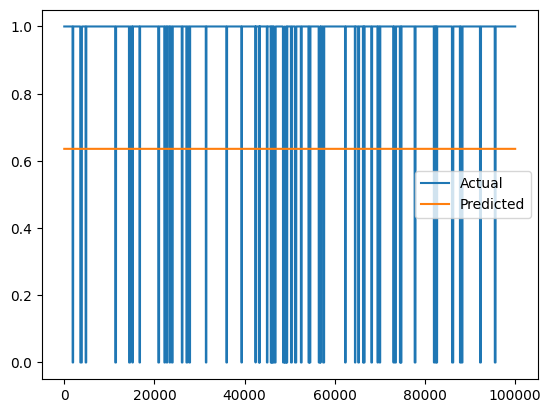

In [32]:
# sequential_model = tf.keras.models.load_model('stacked_lstm.h5')
plt.plot(train_labels, label='Actual')
plt.plot(sequential_model.predict(train_features), label='Predicted')
plt.legend()
plt.show()

In [16]:
sequential_model.save('stacked_model.h5')